# MountainCar Tests

* We use the OpenAI problem MoutainCarContinuous with our PyTorch code
* the PER is also from openAI
* the last cell should be executed before the training loop because it contains utils functions that are used in the loop. It is at the end to make the notebook readable


In [1]:
import torch as t
import torch.nn.functional as F
from torch.nn import LeakyReLU, ReLU, SELU
import numpy.random as npr
import numpy as np
from random import random, sample
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from parse_dataset import *
import icnn
from icnn import ICNN, ICNNBN, ICNNBN2, gradient_step_action, diff_params, clip_gradients, get_q_target, update_parameters_lag
from copy import deepcopy
from utils import variable, moving_avg
from time import time
import evaluation
import importlib
import gym
import math
from replay_buffer import PrioritizedReplayBuffer

## Get random transitions

In [2]:
env = gym.make('MountainCarContinuous-v0')
transitions = []
episodes = 100
iterations = 1000

for e in range(episodes):
    s = env.reset()
    for i in range(iterations):
        action = np.random.uniform(-1,1,(1,)) #env.action_space.sample()
        former = env.env.state*1
        s_, reward, done, info = env.step(action)
        reward *= (reward > 0)*.01
        transitions.append((s, action, reward, s_, done))
        s = s_*1
        if done:
            break

env.reset()

array([-0.44589127,  0.        ])

In [3]:
len(transitions)

99900

In [4]:
print(env.action_space)
print(env.action_space.high,env.action_space.low)
print(env.observation_space.high,env.observation_space.low)
print(env.observation_space)

Box(1,)
[ 1.] [-1.]
[ 0.6   0.07] [-1.2  -0.07]
Box(2,)


## Getting PER

In [5]:
memory = PrioritizedReplayBuffer(500000, .6)
for s,a,r,s_,done in transitions:
    memory.add(*(s,a,r,s_,np.array([done])))

## Building Network

In [6]:
qs = ICNNBN2(3, 20, 2, action_dim=1, gain=math.sqrt(2/1.01), activation=LeakyReLU(.01))
qe = deepcopy(qs)
qe.eval()
print('#params: %s' % np.sum([np.prod(p.data.numpy().shape) for p in qs.parameters()]))

#params: 2367


## Training

In [7]:
learning_rate = 1e-3
optimizer = t.optim.Adam(qs.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
# monitoring
losses = []
td_errors = []
test_td_errors = []
test_average_q_pred = []
test_max_q_pred = []
test_min_q_pred = []
average_q_pred = []
average_q_target = []
max_q_pred = []
min_q_pred = []
max_q_target = []
min_q_target = []
average_a = []
min_a = []
max_a = []
chosen_actions = []


**Note that some functions are redefined in the cell that follows the next one**

**Run it BEFORE!**

5000 steps seen in 569.8208453655243


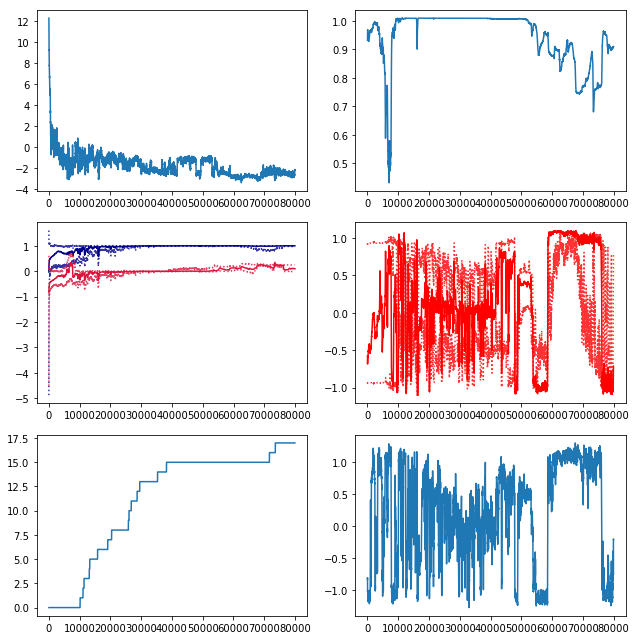

KeyboardInterrupt: 

In [10]:
plt.rcParams['figure.figsize'] = (9,9)
batch_size = 64
global_step = -1
tau = 1e-2
c = 1e6
max_steps_a = 10
gamma = .99
max_steps_beta = 100000
beta0 = .9
beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.
all_rewards = [0]

RMIN, RMAX = 0, 1

noise = 0
outheta = .15
ousigma = .1

ss = env.reset()

while True:
    global_step += 1
    
    # act
    noise -= outheta * noise - ousigma * npr.randn(1)  # noise with momentum
    chosen_action = argmax(qs, variable(ss.reshape((1,-1)))).data.numpy()[0] + noise
    ss_, reward, done, info = env.step(chosen_action)  # actions are clipped to -1,1 internally by env
    reward *= (reward > 0)*.01  # to simplify problem and clip to 0,1
    all_rewards.append(all_rewards[-1]+reward)
    memory.add(*(ss,chosen_action,reward,ss_,np.array([done])))
    ss = ss_*1
    if done:
        ss = env.reset()
    
    # sample
    s,a,r,s_,done,w,idx = memory.sample(batch_size, beta(global_step))
    states = variable(s)
    actions = variable(a.astype(np.float32))
    rewards = variable(r)
    next_states = variable(s_)
    weights = variable(w).squeeze()
    
    # init grad
    optimizer.zero_grad()

    # Compute loss
    pred = qs.forward(states,actions).squeeze()  # Q(s, a)

    target, max_actions = get_q_target(qs, qe, next_states, rewards, batch_size, done, min0=-1, max0=1, gamma=gamma, max_steps_a=max_steps_a) # r + g * max_a' Q(s', a')
    target = t.max(variable(pred.data) - 1., target)  # clip targets (il font comme ca dans le code icnn)
    target = t.min(variable(pred.data) + 1., target)
    assert not target.requires_grad

    loss = huber_loss(pred, target)  # j'ai vu quelques personnes utiliser ca
    loss = loss*weights  # multiplication by the PER coefficients
    loss = t.mean(loss) + c*t.mean(loss_beyond_RMAX(pred, RMIN, RMAX))

    # Update priorities
    td_error = t.abs(pred-target)+1e-2
    memory.update_priorities(idx, td_error.data.numpy())
    
    # Monitoring
    losses.append(loss.data.numpy()[0])
    td_errors.append(td_error.data.numpy().mean())
    average_q_pred.append(t.mean(pred).squeeze().data.numpy()[0])
    max_q_pred.append(t.max(pred).squeeze().data.numpy()[0])
    min_q_pred.append(t.min(pred).squeeze().data.numpy()[0])
    average_q_target.append(t.mean(target).squeeze().data.numpy()[0])
    max_q_target.append(t.max(target).squeeze().data.numpy()[0])
    min_q_target.append(t.min(target).squeeze().data.numpy()[0])
    average_a.append(max_actions.mean(0)[0])
    max_a.append(max_actions.max(0)[0])
    min_a.append(max_actions.min(0)[0])
    chosen_actions.append(chosen_action[0])
    
    # Compute gradients and update weights of the selection network
    loss.backward()
    optimizer.step()
    qs.proj()  # keep weights positive

    # update parameters of the evaluation network. Its weights lag behind
    update_parameters_lag(qs, qe, tau)
    qe.proj()  # keep weights positive
    
    # PLOT
    if global_step % 5000 == 0:
        clear_output(wait=True)
        try:
            print('5000 steps seen in %s' % str(time()-t0))
        except:
            t0 = time()
        t0 = time()

        fig, axes = plt.subplots(3, 2)
        # td error
        axes[0,0].plot(moving_avg(np.log(losses)))
        axes[0,1].plot(moving_avg(td_errors))
        # Q values (target and pred)
        axes[1,0].plot(moving_avg(average_q_pred), label='avg pred', c='darkblue')
        axes[1,0].plot(moving_avg(min_q_pred), label='min pred', c='darkblue', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(max_q_pred), label='max pred', c='darkblue', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(average_q_target), label='avg target', c='crimson')
        axes[1,0].plot(moving_avg(min_q_target), label='min target', c='crimson', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(max_q_target), label='max target', c='crimson', alpha=.8,linestyle=':')
        axes[1,1].plot(moving_avg(average_a), c='r')
        axes[1,1].plot(moving_avg(min_a), c='r', linestyle=':',alpha=.8)
        axes[1,1].plot(moving_avg(max_a), c='r', linestyle=':',alpha=.8)
        axes[2,0].plot(all_rewards)
        axes[2,1].plot(moving_avg(chosen_actions))
        
        plt.tight_layout()
        plt.show()

In [15]:
qs.z_zu_1.weight

Parameter containing:

Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.2025  0.0000  0.4109  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 

# some utils

In [9]:
import torch as t
def loss_beyond_RMAX(x, RMIN, RMAX):
    return (x > RMAX).float()*(x - RMAX)**2 + (x < RMIN).float()*(x - RMIN)**2

def huber_loss(x,y):
    d = x-y
    return .5*(d**2)*(t.abs(d)<1).float() + (t.abs(d) - .5)*(t.abs(d)>=1).float()

def loss_range(a, min0, max0, c):
    return c*(
    (a > max0).float()*t.abs(a[:] - max0) +
    (a < min0).float()*t.abs(a[:] - min0) 
    )

def gradient_step_action(Q, s, a, min0, max0, c=1e5, input_param=None, optimizer=None):
    if input_param is None or optimizer is None:
        input_param = t.nn.Parameter(a.data)
        optimizer = t.optim.Rprop([input_param], lr=5e-1)

    assert len(s) == len(a), 'There should be as many states as there are actions'
    batch_size = len(s)

    # erase previous gradients
    optimizer.zero_grad()

    # trick to get the gradients wrt `a`
    grad = {}
    def f(x):
        grad['a'] = x
    a.register_hook(f)

    # get output (we want to maximize Q, so minimize -Q (the optimizer minimizes by default))
    output = -Q(s, a) + loss_range(a, min0, max0, c)

    # compute gradients
    output.backward(t.FloatTensor(batch_size*[[1.]]))

    # use the gradients that was deceitfully obtained using the hook
    input_param.grad = grad['a']

    # update the action
    optimizer.step()

    # returns the new value of `a` (a pytorch variable), the same thing but wrapped in t.nn.Parameter, and the optimizer
    return variable(input_param.data, requires_grad=True), input_param, optimizer


def get_q_target(Q_select, Q_eval, next_states, rewards, batch_size, done, min0=-1, max0=1, gamma=1., max_steps_a=10):
    Q_target = rewards.squeeze().data.numpy() * 1
    action_dim = Q_select.action_dim
    Q_select.eval()
    Q_eval.eval()

    # identify non-terminal states
    mask = t.from_numpy((1 - done)).byte().view(-1, 1)
    shape = int(next_states.data.numpy().shape[1])
    masked_next_states = next_states.masked_select(mask).resize(int((1 - done).sum()), shape)

    # maximize
    max_action = variable(np.zeros((len(masked_next_states), action_dim)), requires_grad=True).float()
    prev_action = variable(np.zeros((len(masked_next_states), action_dim)), requires_grad=True).float()
    input_param = t.nn.Parameter(max_action.data)
    optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
    for k in range(max_steps_a):
        max_action, input_param, optimizer_for_a = gradient_step_action(Q_select, masked_next_states, max_action, min0, max0, input_param=input_param, c=1e6, optimizer=optimizer_for_a)
        if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
            break
        prev_action = max_action * 1

    pred = Q_eval.forward(masked_next_states, max_action).squeeze()

    np_mask = mask.squeeze().numpy()
    np_mask = [k for k in range(batch_size) if np_mask[k] == 1]
    Q_target[np_mask] += gamma * (pred.data.numpy())

    Q_select.train()

    return variable(Q_target), max_action.data.numpy()


def argmax(Q_select, s, max_steps_a=10, min0=-1, max0=1):
    Q_select.eval()
    # maximize
    max_action = variable(np.zeros((len(s), 1)), requires_grad=True).float()
    prev_action = variable(np.zeros((len(s), 1)), requires_grad=True).float()
    input_param = t.nn.Parameter(max_action.data)
    optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
    for k in range(max_steps_a):
        max_action, input_param, optimizer_for_a = gradient_step_action(Q_select, s, max_action, min0, max0, input_param=input_param, optimizer=optimizer_for_a)
        if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
            break
        prev_action = max_action * 1
    Q_select.train()
    return max_action

# Test model

In [17]:
qs.eval()

ICNNBN2 (
  (activation): LeakyReLU (0.01)
  (u0): Linear (2 -> 20)
  (bn_u0): BatchNorm1d(20, eps=0.001, momentum=0.9, affine=True)
  (u1): Linear (20 -> 20)
  (z_u0): Linear (2 -> 20)
  (z_au0): Linear (2 -> 1)
  (z_au_0): Linear (1 -> 20)
  (z_u1): Linear (20 -> 20)
  (z_au1): Linear (20 -> 1)
  (z_au_1): Linear (1 -> 20)
  (z_zu1): Linear (20 -> 20)
  (z_zu_1): Linear (20 -> 20)
  (z_u2): Linear (20 -> 1)
  (z_au2): Linear (20 -> 1)
  (z_au_2): Linear (1 -> 1)
  (z_zu2): Linear (20 -> 20)
  (z_zu_2): Linear (20 -> 1)
)

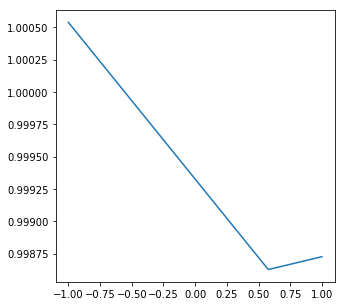

In [34]:
plt.rcParams['figure.figsize'] = (5,5)
s = variable(np.array(100*[[-1, 0.05]]))
a = variable(np.linspace(-1,1,100).reshape((100,1)))
plt.plot(np.linspace(-1,1,100).reshape((100,1)), qs(s,a).data.numpy().squeeze())
plt.show()

In [ ]:
np.array(100*[[-.4, 0.01]]).shape

In [16]:
qs.z_zu2.weight

Parameter containing:

Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.2039  0.3542  0.3616  0.0584  0.1318  0.3292  0.4679  0.3292  0.2521  0.4201
 0.0015  0.0660  0.0007  0.0000  0.0003  0.0803  0.0017  0.0890  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.4552  0.4495  0.4269  0.0343  0.4660  0.0148  0.4444  0.3142  0.0522  0.2657
 0.0449  0.1085  0.3093  0.5220  0.1717  0.1962  0.1201  0.1113  0.3296  0.3284
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.1708  0.3563  0.1866  0.0006  0.0033  0.1977  0.1085  0.2036  0.0059  0.1814
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0001  0.0000  0.0000  0.0000  0.0000
 